In [17]:
import numpy as np
from spec_id import Analyze_Stack_avgage,Likelihood_contours, Make_model_list,Stack_spec_normwmean,Stack_model_normwmean
import matplotlib.pyplot as plt
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [15]:
ids,speclist,lmass,rshift,rad,sig,comp=np.array(Readfile('masslist_mar22.dat',is_float=False))
lmass,rshift,rad,sig,comp=np.array([lmass,rshift,rad,sig,comp]).astype(float)

IDc=[]  # compact sample
IDd=[]  # diffuse sample

IDmL=[]  # low mass sample
IDmH=[]  # high mass sample

for i in range(len(ids)):
    if 0.11 < comp[i]:
        IDd.append(i)
    if 0.11 > comp[i]:
        IDc.append(i)
    if 10.931 > lmass[i]:
        IDmL.append(i)
    if 10.931 < lmass[i]:
        IDmH.append(i)

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [20]:
def Stack_spec_normwmean2(spec, redshifts, wv):
    flgrid = np.zeros([len(spec), len(wv)])
    errgrid = np.zeros([len(spec), len(wv)])
    for i in range(len(spec)):
        wave, flux, error = np.load(spec[i])
        if spec[i] == 'spec_stacks_jan24/s40597_stack.npy':
            IDW = []
            for ii in range(len(wave)):
                if 7950 < wave[ii] < 11000:
                    IDW.append(ii)
    
        # if spec[i] == 'spec_stacks_jan24/n21156_stack.npy':
        #     IDW = []
        #     for ii in range(len(wave)):
        #         if 7950 < wave[ii] < 11100:
        #             IDW.append(ii)
    
        else:
            IDW = []
            for ii in range(len(wave)):
                if 7950 < wave[ii] < 11300:
                    IDW.append(ii)

        wave, flux, error = np.array([wave[IDW], flux[IDW], error[IDW]])
        
        if spec[i] == 'spec_stacks_jan24/n21156_stack.npy':
            IDer = []
            for ii in range(len(wave)):
                if 4855*(1+redshifts[i]) <= wave[ii] <= 4880*(1+redshifts[i]):
                    IDer.append(ii)
            error[IDer]=100
        
        if spec[i] == 'spec_stacks_jan24/s39170_stack.npy':
            IDer = []
            for ii in range(len(wave)):
                if 4860*(1+redshifts[i]) <= wave[ii] <= 4880*(1+redshifts[i]):
                    IDer.append(ii)
            error[IDer]=100
        
        wave /= (1 + redshifts[i])
        mask = np.array([wave[0] < U < wave[-1] for U in wv])
        ifl = interp1d(wave, flux)
        ier = interp1d(wave, error)
        reg = np.arange(4000, 4210, 1)
        Cr = np.trapz(ifl(reg), reg)
        flgrid[i][mask] = ifl(wv[mask]) / Cr
        errgrid[i][mask] = ier(wv[mask]) / Cr
    ################

    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / np.sum(weigrid[i])
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    ###take out nans

    IDX = [U for U in range(len(wv)) if stack[U] > 0]

    return wv[IDX], stack[IDX], err[IDX]

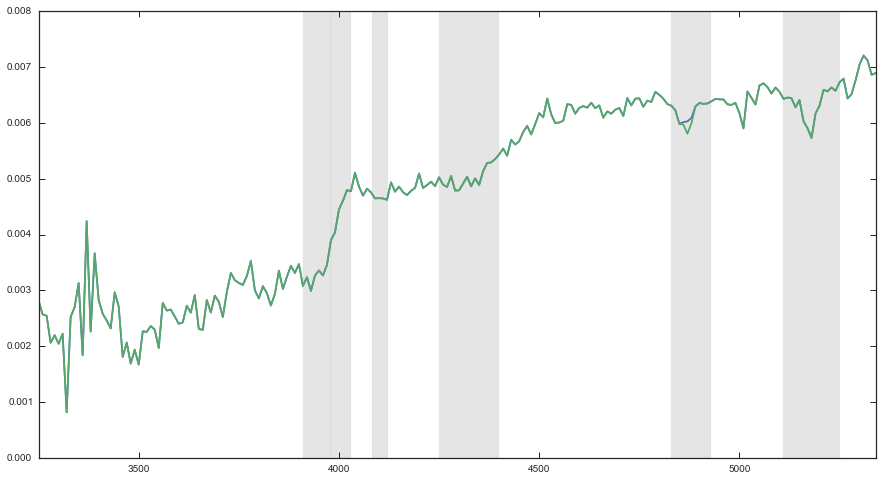

In [21]:
%matplotlib inline

wv,fl,er=Stack_spec_normwmean(speclist[IDc],rshift[IDc],np.arange(3250,5350,10))
wv2,fl2,er2=Stack_spec_normwmean2(speclist[IDc],rshift[IDc],np.arange(3250,5350,10))

plt.figure(figsize=[15,8])
plt.plot(wv,fl)
plt.plot(wv2,fl2)
plt.axvspan(3910, 3979, color='k', alpha=.1)
plt.axvspan(3981, 4030, color='k', alpha=.1)
plt.axvspan(4082, 4122, color='k', alpha=.1)
plt.axvspan(4250, 4400, color='k', alpha=.1)
plt.axvspan(4830, 4930, color='k', alpha=.1)
plt.axvspan(5109, 5250, color='k', alpha=.1)
plt.xlim(min(wv),max(wv))
plt.show()
plt.close()